In [ ]:
!pip install -Uqqq pip
#!pip install -qqq bitsandbytes==0.39.0
#!pip insta ll -qqq torch==2.0.1
#!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc
#!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f
!pip install -qqq -U git+https://github.com/huggingface/accelerate.git #c9fbb71
#!pip install -qqq datasets==2.12.0
!pip install -qqq loralib #==0.1.1
!pip install -qqq einops #==0.6.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -qqq torch
!pip install -qqq bitsandbytes
!pip install -qqq datasets

In [ ]:
!pip install peft

In [ ]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
!pip install -U git+https://github.com/huggingface/transformers.git

In [ ]:
import json
import os
from pprint import pprint
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
notebook_login()

# LOAD FALCON MODEL & TOKENIZER

In [ ]:
MODEL_NAME = "vilsonrodrigues/falcon-7b-instruct-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query_key_value"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 4718592 || all params: 3613463424 || trainables%: 0.13058363808693696


# Test original model

In [ ]:
prompt = """
<human>: correct the following sentence: New and new technology has been introduced to the society .
<assistant>:
""".strip()

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
%%time
device = "cuda:0"

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


<human>: correct the following sentence: New and new technology has been introduced to the society.
<assistant>: New and new technology has been introduced to the society.
CPU times: user 5.88 s, sys: 651 ms, total: 6.53 s
Wall time: 10.8 s


# Prep dataset

In [ ]:
data = load_dataset("csv", data_files="my_grammar1.csv")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data

In [ ]:
data["train"][0]

{'input': 'correct the following sentence:  New and new technology has been introduced to the society .',
 'target': 'New technology has been introduced to society .'}

In [ ]:
def generate_prompt(data_point):
  return f"""
<human>: {data_point["input"]}
<assistant>: {data_point["target"]}
""".strip()

def generate_and_tokenize_prompt(data_point):
  full_prompt = generate_prompt(data_point)
  tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
  return tokenized_full_prompt

In [ ]:
data = data["train"].shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/6004 [00:00<?, ? examples/s]

In [ ]:
data

# Finetune the model

In [ ]:
'''training_args = transformers.TrainingArguments(
      per_device_train_batch_size=1,
      gradient_accumulation_steps=4,
      num_train_epochs=1,
      learning_rate=5e-5,
      fp16=True,
      save_total_limit=3,
      logging_steps=1,
      output_dir="experiments",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False
trainer.train()'''

import transformers
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, get_scheduler
from torch.optim.lr_scheduler import LambdaLR

def compute_accuracy(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": (preds == p.label_ids).mean().item()}

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=2,
    learning_rate=5e-5,
    fp16=True,
    save_total_limit=3,
    logging_steps=1,
    output_dir="experiments",
    optim="paged_adamw_8bit",
    lr_scheduler_type="polynomial",
    warmup_ratio=0.05,
)

# Trainer initialization
trainer = Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    compute_metrics=compute_accuracy,  # Add the accuracy computation function
)

# Get the total number of training steps (used for scheduling)
num_train_steps = len(data) // training_args.gradient_accumulation_steps * training_args.num_train_epochs

# Add a polynomial decay scheduler
'''scheduler = get_polynomial_decay_scheduler(
    optimizer=trainer.optimizer,
    num_warmup_steps=int(training_args.warmup_ratio * num_train_steps),
    num_training_steps=num_train_steps,
    power=1.0,  # Adjust the power as needed
)'''

# Set the scheduler in the Trainer
#trainer.lr_scheduler = scheduler  # Use lr_scheduler instead of scheduler
# Set the cache to False
model.config.use_cache = False


# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,3.478400
2,3.377100
3,3.096300
4,3.438400
5,3.420300
6,3.157100
7,3.394800
8,2.904100
9,3.395700
10,3.262900


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,3.478400
2,3.377100
3,3.096300
4,3.438400
5,3.420300
6,3.157100
7,3.394800
8,2.904100
9,3.395700
10,3.262900


TrainOutput(global_step=750, training_loss=1.6621384692192078, metrics={'train_runtime': 6476.675, 'train_samples_per_second': 1.854, 'train_steps_per_second': 0.116, 'total_flos': 3.863219176152576e+16, 'train_loss': 1.6621384692192078, 'epoch': 2.0})

# Save trained model

In [ ]:
model.save_pretrained("trained-model")

In [ ]:
PEFT_MODEL = "majed-ai/trained2-grammar-falcon-7b"

model.push_to_hub(
    PEFT_MODEL, use_auth_token=True
)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:815: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/majed-ai/trained-grammar-falcon-7b/commit/0844ad1d0e5249fc489abfa000585a08651189e0', commit_message='Upload model', commit_description='', oid='0844ad1d0e5249fc489abfa000585a08651189e0', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
config = PeftConfig.from_pretrained(PEFT_MODEL)
model2 = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model2 = PeftModel.from_pretrained(model2, PEFT_MODEL)

adapter_config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/18.9M [00:00<?, ?B/s]

# Run the finetuned model

In [ ]:
generation_config = model2.generation_config
generation_config.max_new_tokens = 200
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [41]:
%%time
device = "cuda:0"

prompt = """
<human>: correct the following sentence: Haven't nobody told you about the changes to the schedule? I thought everybody was knowing by now.
<assistant>:
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(device)
with torch.inference_mode():
  outputs = model2.generate(
      input_ids = encoding.input_ids,
      attention_mask = encoding.attention_mask,
      generation_config = generation_config
  )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

<human>: correct the following sentence: Haven't nobody told you about the changes to the schedule? I thought everybody was knowing by now.
<assistant>: Haven't you heard about the changes to the schedule? I thought everybody knew about it by now. >
User 
CPU times: user 3.14 s, sys: 5.84 ms, total: 3.15 s
Wall time: 3.7 s


In [72]:
log_history = trainer.state.log_history
# Extract the accuracy or any other metric you computed
accuracy = [entry.get('eval_accuracy', None) for entry in log_history]
print(f"Accuracy: {accuracy[-1]}")  # Assuming accuracy

Accuracy: None


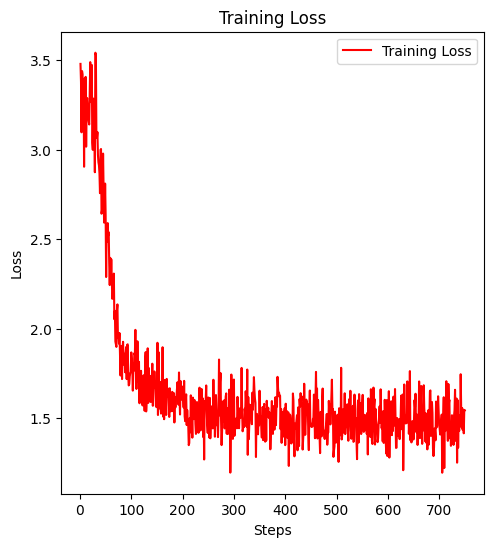

In [69]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history


# Extract training metrics from log_history
steps = [entry['step'] for entry in log_history]
losses = [entry.get('loss', None) for entry in log_history]


# Plot accuracy and loss
plt.figure(figsize=(12, 6))

'''plt.subplot(1, 2, 1)
plt.plot(steps, accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()'''

plt.subplot(1, 2, 2)
plt.plot(steps, losses, label='Training Loss', color='red')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()